# Titanic Kaggle Competition

Get the [data for the Kaggle Titanic Competition](https://www.kaggle.com/c/titanic/data).

Some useful tutorials on Kaggle and blogs:
- [Feature undersatdning from plots](https://www.kaggle.com/saisivasriram/titanic-feature-understanding-from-plots)
- [Detailed ensemble learning](https://www.kaggle.com/littleraj30/detailed-ensemble-v-s-other-model-on-titanic)
- [How to score in the top 9%](https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9)
- [For learning Logistic Regression](https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python)
- [A great simple well-explained blog post on logistic regression](https://mashimo.wordpress.com/2018/03/31/logistic-regression-using-sklearn/)

Import libraries

In [1]:
# systems
from pathlib import Path
# data handling
import pandas as pd
import numpy as np
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
path = Path('../data/titanic')
list(path.glob('*'))

[PosixPath('../data/titanic/train.csv'),
 PosixPath('../data/titanic/test.csv'),
 PosixPath('../data/titanic/gender_submission.csv'),
 PosixPath('../data/titanic/titanic.zip')]

### 1. Data Exploration

In [3]:
train_path = path.joinpath('train.csv')
train_data = pd.read_csv(train_path)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.shape

(891, 12)

In [5]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

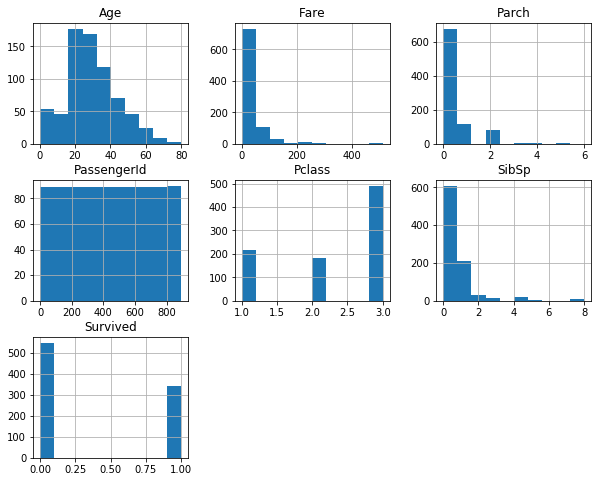

In [6]:
train_data.hist(figsize=(10,8));

/home/datalass1/miniconda3/envs/100-days-of-code/lib/python3.7/site-packages/pandas/plotting/_core.py:1208: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  return ax.bar(x, y, w, bottom=start, log=log, **kwds)
/home/datalass1/miniconda3/envs/100-days-of-code/lib/python3.7/site-packages/pandas/plotting/_core.py:1208: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  return ax.bar(x, y, w, bottom=start, log=log, **kwds)


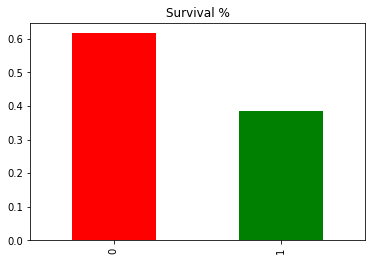

In [7]:
(train_data.Survived
         .value_counts(normalize=True)
         .plot(kind='bar', color=['R', 'G']))
plt.title('Survival %');

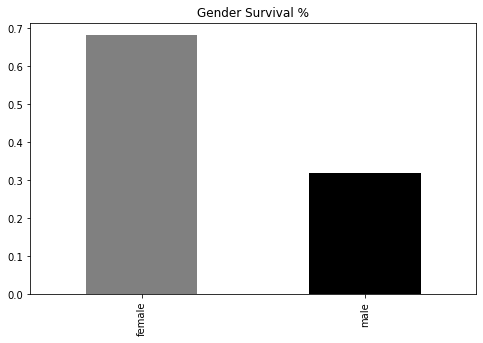

In [8]:
plt.figure(figsize=(8,5))
(train_data.Sex[train_data.Survived == 1]
             .value_counts(normalize=True)
             .plot(kind='bar', color=['Grey', 'Black']))
plt.title('Gender Survival %');

More females survived.

Find the pairwise correlation of all columns in the dataframe. Any non-numeric data type columns in the dataframe are ignored.

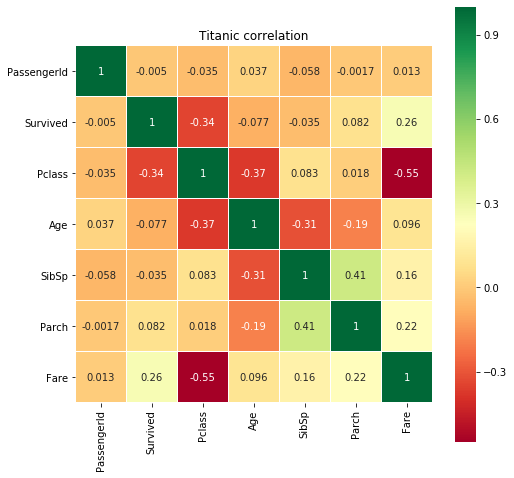

In [9]:
corr = train_data.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, vmax=1, square=True, cmap='RdYlGn', linewidths=0.1, annot=True)
plt.title('Titanic correlation');

In [10]:
train_data.corr()['Survived'].sort_values()

Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
PassengerId   -0.005007
Parch          0.081629
Fare           0.257307
Survived       1.000000
Name: Survived, dtype: float64

Most people survived because of their class, fare, age then parch. 

The box plot visualises survival chance of 1st, 2nd and 3rd class passengers based on age. 

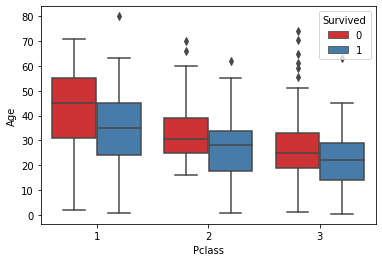

In [11]:
sns.boxplot(x='Pclass', y='Age', hue='Survived', data=train_data, palette='Set1');

Kernel Density Estimation (KDE) visualisation for age within class. Kernel density from [pandas.plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.kde.html) is a non-parametric smoothing technique which uses Gaussian kernels and includes automatic bandwidth determination. [A useful explanation with interactive javascript plots](https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html?p=28).

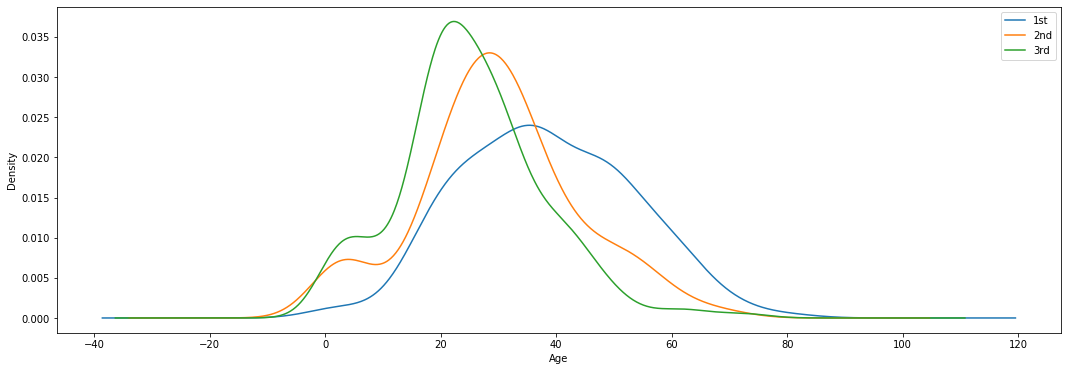

In [12]:
fig = plt.figure(figsize=(18,6))
for x in [1,2,3]:
    train_data.Age[train_data.Pclass == x].plot(kind='kde')
plt.legend(('1st', '2nd', '3rd'))
plt.xlabel('Age')
plt.show()

In [13]:
print(' Youngest: ', min(train_data.Age), '\n', 'Oldest: ', max(train_data.Age))

 Youngest:  0.42 
 Oldest:  80.0


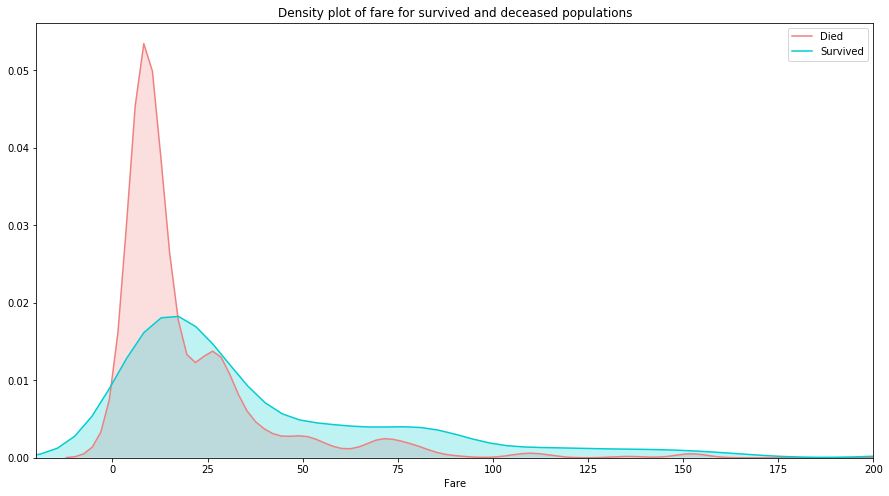

In [14]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(train_data['Fare'][train_data.Survived == 0],
                color='lightcoral', shade=True)
sns.kdeplot(train_data['Fare'][train_data.Survived == 1],
           color='darkturquoise', shade=True)
plt.legend(['Died', 'Survived'])
plt.title('Density plot of fare for survived and deceased populations')
ax.set(xlabel='Fare')
plt.xlim(-20, 200)
plt.show()

In [15]:
for num, i in enumerate(range(1,4)):
    age = train_data.groupby('Pclass').get_group(i).Age.mean()
    print('class', num+1, 'mean age:', age)

class 1 mean age: 38.233440860215055
class 2 mean age: 29.87763005780347
class 3 mean age: 25.14061971830986


Were people with larger families less or more likely to survive?
- SibSp	# of siblings / spouses aboard the Titanic	
- Parch	# of parents / children aboard the Titanic

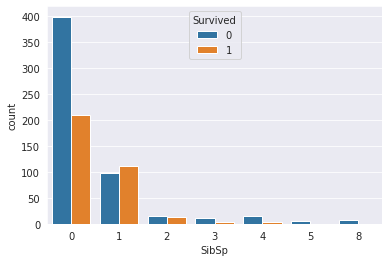

In [16]:
sns.set_style(style='darkgrid')
sns.countplot(x='SibSp', hue='Survived', data=train_data);

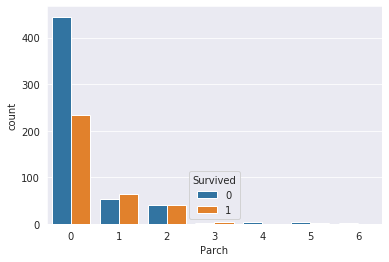

In [17]:
sns.countplot(x='Parch', hue='Survived', data=train_data);

### 2. Feature Engineering: Create New Features

Create a new feature for the Title of a passengers name, create smaller categories based on title/rank/honorific and then map the Title column. 

In [18]:
def create_title_column_and_standardise(data):
    data['Title'] = (data.Name
                       .apply(lambda name: name.split(',')[1]
                             .split('.')[0].strip()))
    print('Unique titles of original dataset: ', '\n', 
          data.Title.unique())
    simple_titles = {'Mr': 'Mr', 'Mrs': 'Ms', 'Miss': 'Ms', 'Master': 'Master',
    'Don': 'Noble','Rev': 'Rev', 'Dr': 'Dr', 'Mme': 'Ms', 'Mlle': 'Ms',
    'Ms': 'Ms', 'Major': 'Officer', 'Lady': 'Noble', 'Sir': 'Noble',
    'Mlle': 'Ms', 'Col': 'Officer', 'Capt': 'Officer', 'the Countess': 'Noble',
    'Jonkheer': 'Noble'}
    data.Title = data.Title.map(simple_titles)
    print('Standardised Titles: ', '\n', 
          data.Title.value_counts())

In [19]:
create_title_column_and_standardise(train_data)

Unique titles of original dataset:  
 ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']
Standardised Titles:  
 Mr         517
Ms         311
Master      40
Dr           7
Rev          6
Noble        5
Officer      5
Name: Title, dtype: int64


Create a new feature for family groups

In [20]:
def create_family_column(data):
    train_data['Members'] = train_data['Parch'] + train_data['SibSp']
    data.Members.replace([8,9,10,11], 7, inplace=True)

In [21]:
create_family_column(train_data)

In [22]:
train_data.Members.value_counts().sort_values()

6     12
7     13
4     15
5     22
3     29
2    102
1    161
0    537
Name: Members, dtype: int64

### 3. Fill NaN values

A machine learning computation will not work if there is missing data

In [23]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
Members          0
dtype: int64

#### Age
Fill age according to Pclass, Sex and Title. [Pandas guidance on missing data](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html).

In [24]:
def fill_missing_age_values(data):
    grouped = data.groupby(['Sex', 'Pclass', 'Title'])
    print(grouped.Age.median())
    data.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))
    
fill_missing_age_values(train_data)

Sex     Pclass  Title  
female  1       Dr         49.0
                Ms         35.0
                Noble      40.5
        2       Ms         28.0
        3       Ms         21.5
male    1       Dr         44.0
                Master      4.0
                Mr         40.0
                Noble      40.0
                Officer    56.0
        2       Dr         38.5
                Master      1.0
                Mr         31.0
                Rev        46.5
        3       Master      4.0
                Mr         26.0
Name: Age, dtype: float64


#### Embarked
Fill in the null values in Embarked feature.
C = Cherbourg, Q = Queenstown, S = Southampton

In [25]:
train_data[train_data.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Members
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Ms,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Ms,0


Both paid $80 and travelled first class.

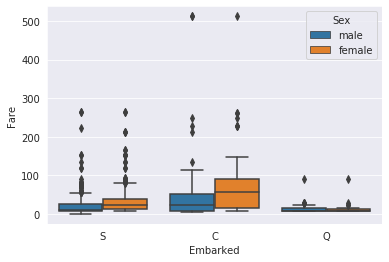

In [26]:
sns.boxplot(x='Embarked', y='Fare', hue='Sex', data=train_data);

Higher paying females travels from Cherbourg. 

In [27]:
train_data['Embarked'] = train_data['Embarked'].fillna('C')

#### Cabin numbers

In [28]:
def clean_cabin(x):
    try:
        return x[0]
    except:
        return 'U'
train_data['Cabin'] = train_data.Cabin.apply(clean_cabin)
train_data['Cabin'].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
Title          891 non-null object
Members        891 non-null int64
dtypes: float64(2), int64(6), object(6)
memory usage: 97.5+ KB


### 4. Feature Engineering: categorical data to numerical using one hot encoding and feature scaling

The last step to perform before we can begin our modeling is convert all our categorical features to numbers. Random Forest and Logistic Regression algorithms can only take an array of numbers as an input, not names or letters. 

A [great article by Laurae](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931) on finding the best data structure for the machine learning model.

Approaches:
1. Label encoding: simply converting each value in a column to a number. Using `astype` to convert 'object' to 'category' then pandas `.cat.codes` to assign an encoded variable. The problem can be we might confuse our model into thinking that a column has data with some kind of order or hierarchy
2. One hot encoding: implemented in scikit-learn as `sklearn.preprocessing.OneHotEncoder`. Dummy coding/one-hot encoding are also implemented in Pandas as `pandas.get_dummies`. 

In [30]:
train_data['Sex'] = train_data.Sex.map({'male': 0, 'female': 1})

In [31]:
title_encoded = pd.get_dummies(train_data.Title, prefix='Title')
cabin_encoded = pd.get_dummies(train_data.Cabin, prefix='Deck')
embarked_encoded = pd.get_dummies(train_data.Embarked, prefix='Embarked')
pclass_encoded = pd.get_dummies(train_data.Pclass, prefix='Pclass')
members_encoded = pd.get_dummies(train_data.Members, prefix='Members')

In [32]:
titanic_train = pd.concat([train_data, title_encoded, 
                          cabin_encoded, embarked_encoded, pclass_encoded, members_encoded], axis=1)

In [33]:
titanic_train.drop(['Name', 'Ticket', 'Title',
                   'Cabin', 'Embarked', 'PassengerId',
                   'SibSp', 'Parch', 'Pclass', 'Members'], axis=1, inplace=True)
titanic_train.shape

(891, 34)

In [34]:
# titanic_train.T

**Feature Scaling**

There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

Min-max scaling (many people call this normalization) is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. 

Standardization is quite different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. 

*WARNING: It is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).*

Source: [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch02.html)

Apply a Standard Scalar to numerical values.

The idea behind StandardScaler is that it will normalize the features (each column of X individually) so that each column/feature/variable will have mean = 0 and standard deviation = 1 [Source: stackoverflow](https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler)

In [35]:
titanic_train.select_dtypes(['float64','int64'])[:2]

,Survived,Sex,Age,Fare
0,0,0,22.0,7.2500
1,1,1,38.0,71.2833


In [36]:
ss_scalar = StandardScaler()
train_data_numerical = (list(titanic_train
                             .select_dtypes(['float64','int64'])
                             .columns))
train_data_numerical.remove('Survived')
train_data_numerical.remove('Sex');train_data_numerical

['Age', 'Fare']

In [37]:
titanic_train_ss = pd.DataFrame(data=titanic_train)
titanic_train_ss[train_data_numerical] = (ss_scalar
                                          .fit_transform(titanic_train_ss[train_data_numerical]))

In [38]:
# titanic_train_ss.head().T

In [39]:
titanic_train_ss.shape

(891, 34)

### Data for Machine Learning

In [40]:
X = titanic_train_ss.drop('Survived', axis=1).values
y = titanic_train_ss.Survived.values

In [41]:
X.shape, y.shape

((891, 33), (891,))

Split the dataset into training and validation. The validation set should be used to see how well the model performs on unseen data.

In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.2,
                                                     random_state=7)

## 5. Ready for Machine Learning

### 1. [Logistic Regression](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html)

- Logistic regression is a classification algorithm
- Logistic regression works on **nominal** variables to model the relationship between a number of independent variable(s) *x* and dependent variable *y*. Goal: to find the regression coefficients. 
- uses the logistic sigmoid function to return a probability value. A probability values always falls between 0 and 1. 
- using scikit-learn `Logistic Regression` function will apply regularization by default. [Andrew Ng coursera Machine Learning course](https://www.coursera.org/lecture/machine-learning/regularized-logistic-regression-4BHEy) has a good video explaining this: regularization can help take care of overfitting. 

In [43]:
log_reg = LogisticRegression(solver='liblinear', max_iter=200)
log_reg_model = log_reg.fit(X_train, y_train)

In [44]:
log_score_train = log_reg_model.score(X_train, y_train)
log_score_valid = log_reg_model.score(X_valid, y_valid)
print('train score: {}\nvalid score: {}'.format(log_score_train, log_score_valid))

train score: 0.8539325842696629
valid score: 0.7821229050279329


Interpreting the logistic regression model

In [45]:
intercept = log_reg_model.intercept_
weights = log_reg_model.coef_
print('logistic regression: intercept = {} coefficients = weights {}'.format(intercept, weights))

logistic regression: intercept = [-0.44252905] coefficients = weights [[ 1.16790971 -0.39154323  0.11977934 -0.65611956  1.3384062  -0.97839066
   1.00813533 -0.06540886 -0.32823118 -0.76092032 -0.27631296  0.06046461
  -0.16429167  0.34967403  0.88791783  0.13548703 -0.40441235 -0.22932595
  -0.80172963  0.16561487 -0.18975712 -0.4183868   0.39040663  0.05792123
  -0.89085691  0.93218356  0.52355283  1.05268188  0.94769227 -0.9734256
  -1.34949836 -0.29401234 -1.28170328]]


Confusion martix: to look at the validation performance

In [46]:
y_pred_valid = log_reg_model.predict(X_valid)

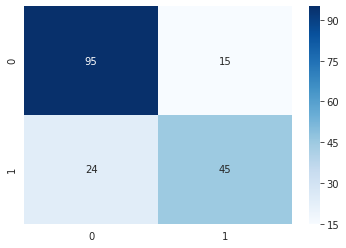

In [47]:
cm = confusion_matrix(y_valid, y_pred_valid)
df_cm = pd.DataFrame(cm, index=[0,1], columns = [0,1])
plt.figure(figsize=(6,4))
sns.heatmap(df_cm, annot=True, cmap='Blues');

### 2. Random Forest

[This youtube video](https://www.youtube.com/watch?v=0GrciaGYzV0) from Mike Bernico

It useful to benchmark with various different models. So using a small number of estimators or a subset of the data is used to begin.

[Predicting the Survival of Titanic Passengers blog](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8)

In [48]:
rf_v1 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42) #oob mean out of bag
rf_model_v1 = rf_v1.fit(X_train, y_train)

In [49]:
rf_score_train_v1 = rf_model_v1.score(X_train, y_train)
rf_score_valid_v1 = rf_model_v1.score(X_valid, y_valid)
print('rf train score: {}\nrf valid score: {}'.format(rf_score_train_v1, rf_score_valid_v1))

rf train score: 0.9873595505617978
rf valid score: 0.7877094972067039


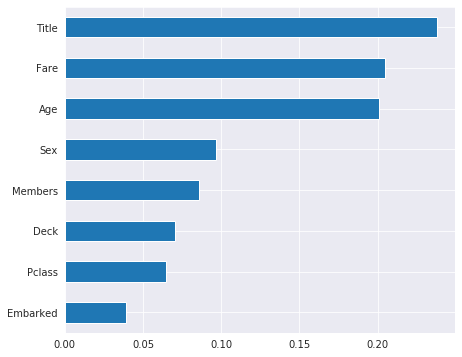

In [50]:
def agg_values(categories:list, model, features):
    '''
    Based on code by Mike Bernico (https://www.youtube.com/watch?v=0GrciaGYzV0)
    
    Graphs the feature importances of a random decision forest using a horizontal bar chart.
    
    Inputs
    ------
    - categories: a list of column name prefixes 
        e.g. ['Age', 'Fare', 'Title', 'Deck', 'Embarked', 'Pclass', 'Members', 'Sex']
    - model: random forest model
    - features: all feature names from the training data
    '''
    
    feature_dict = dict(zip(features, model.feature_importances_))
    sum_value = []
    if categories:
        for col_name in categories:
            sum_item = sum(x for i, x in feature_dict.items() if col_name in i)
            sum_value.append(sum_item)
    (pd.Series(sum_value, index=categories)
     .sort_values()
     .plot(kind='barh', figsize=(7,6)));
    
agg_values(categories=['Age', 'Fare', 'Title', 'Deck', 'Embarked', 'Pclass', 'Members', 'Sex'],
          model=rf_model_v1,
          features=titanic_train.drop('Survived', axis=1).columns)

#### The model looks like it is really overfitting!

Random forest is placing a higher score on the scaled numerical values! Sex is also not one-hot-encoded, could I get better results if I have a sex_female and sex_male column? What about not scaling the continuous features? 

In [51]:
titanic_train['Sex'] = titanic_train.Sex.map({0: 'Male', 1: 'Female'})
sex_encoded = pd.get_dummies(titanic_train.Sex, prefix='Sex')
titanic_train_v2 = pd.concat([titanic_train, sex_encoded], axis=1).drop(['Sex'], axis=1)

In [52]:
headers = titanic_train_v2.drop('Survived', axis=1).columns

In [53]:
X_v2 = titanic_train_v2.drop('Survived', axis=1).values
y_v2 = titanic_train_v2.Survived.values
X_train_v2, X_valid_v2, y_train_v2, y_valid_v2 = train_test_split(X_v2, y_v2, 
                                                      test_size=0.2,
                                                     random_state=7)

In [54]:
X_valid_v2.shape

(179, 34)

In [55]:
rf_v2 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf_model_v2 = rf_v2.fit(X_train_v2, y_train_v2)

In [56]:
rf_score_train_v2 = rf_model_v2.score(X_train_v2, y_train_v2)
rf_score_valid_v2 = rf_model_v2.score(X_valid_v2, y_valid_v2)
print('rf train score: {}\nrf valid score: {}'.format(rf_score_train_v2, rf_score_valid_v2))

rf train score: 0.9873595505617978
rf valid score: 0.776536312849162


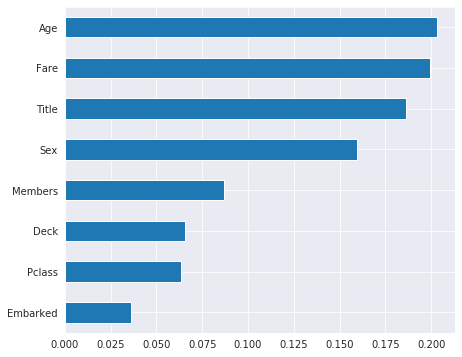

In [57]:
agg_values(categories=['Age', 'Fare', 'Title', 'Deck', 'Embarked', 'Pclass', 'Members', 'Sex'],
          model=rf_model_v2,
          features=titanic_train_v2.drop('Survived', axis=1).columns)

A small difference but not a lot. 

### Parameter Tuning

In [58]:
results = []
n_estimators_options = [30,50,100,200,500,1000,2000]
for trees in n_estimators_options:
    rf = RandomForestClassifier(trees, oob_score=True, n_jobs=-1, random_state=42)
    rf_model = rf.fit(X_train_v2, y_train_v2)
    print(trees, " trees")
    rf_score_train = rf_model.score(X_train_v2, y_train_v2)
    rf_score_valid = rf_model.score(X_valid_v2, y_valid_v2)
    print('rf train score: {}\nrf valid score: {}'.format(rf_score_train, rf_score_valid))

30  trees
rf train score: 0.9845505617977528
rf valid score: 0.8268156424581006
50  trees
rf train score: 0.9873595505617978
rf valid score: 0.7877094972067039
100  trees
rf train score: 0.9873595505617978
rf valid score: 0.776536312849162
200  trees
rf train score: 0.9873595505617978
rf valid score: 0.7821229050279329
500  trees
rf train score: 0.9873595505617978
rf valid score: 0.7877094972067039
1000  trees
rf train score: 0.9873595505617978
rf valid score: 0.7877094972067039
2000  trees
rf train score: 0.9873595505617978
rf valid score: 0.7932960893854749


The less or more trees the better!

#### Lets try one more time with a simpler model

In [59]:
titanic_df_v2 = pd.get_dummies(titanic_train_ss['Sex'])

In [60]:
simple_df = titanic_train_ss.join(titanic_df_v2['Female'])

In [61]:
simple_df.columns

Index(['Survived', 'Sex', 'Age', 'Fare', 'Title_Dr', 'Title_Master',
       'Title_Mr', 'Title_Ms', 'Title_Noble', 'Title_Officer', 'Title_Rev',
       'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
       'Deck_T', 'Deck_U', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Members_0', 'Members_1',
       'Members_2', 'Members_3', 'Members_4', 'Members_5', 'Members_6',
       'Members_7', 'Female'],
      dtype='object')

In [62]:
simple_df = simple_df.drop(columns=['Sex', 'Title_Dr', 'Title_Master','Title_Mr', 'Title_Ms', 'Title_Noble',
                'Title_Officer', 'Title_Rev','Deck_A', 'Deck_B', 
                'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
                'Deck_T', 'Deck_U', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
                'Members_0', 'Members_1', 'Members_2', 'Members_3', 
                'Members_4', 'Members_5', 'Members_6','Members_7'])

In [63]:
X = simple_df.drop(columns='Survived')

In [64]:
y = simple_df['Survived']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [66]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [67]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [72]:
rf.score(X_train, y_train)

0.9805389221556886

In [68]:
rf.score(X_test, y_test)

0.8116591928251121

In [69]:
X_train.head()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Female
298,0.812232,-0.034314,1,0,0,0
884,-0.308990,-0.506472,0,0,1,0
247,-0.383738,-0.356469,0,1,0,1
478,-0.533235,-0.496993,0,0,1,0
305,-2.108926,2.402990,1,0,0,0


In conclusion less is more!

### 3. XG Boost

### 4. SVM